In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Dierckx, Diffusity

┌ Info: Precompiling AlphaBeta [d77d55e1-23be-40c5-8652-b23c35d89ba5]
└ @ Base loading.jl:1278
┌ Info: Precompiling Diffusity [fca15081-c8d4-4aca-bcfd-1103cbe75c6b]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

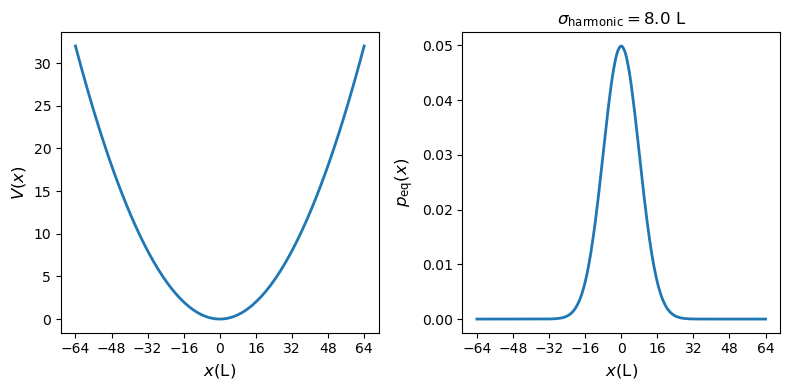

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [4]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
Nphoton = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval Nphoton
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [5]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

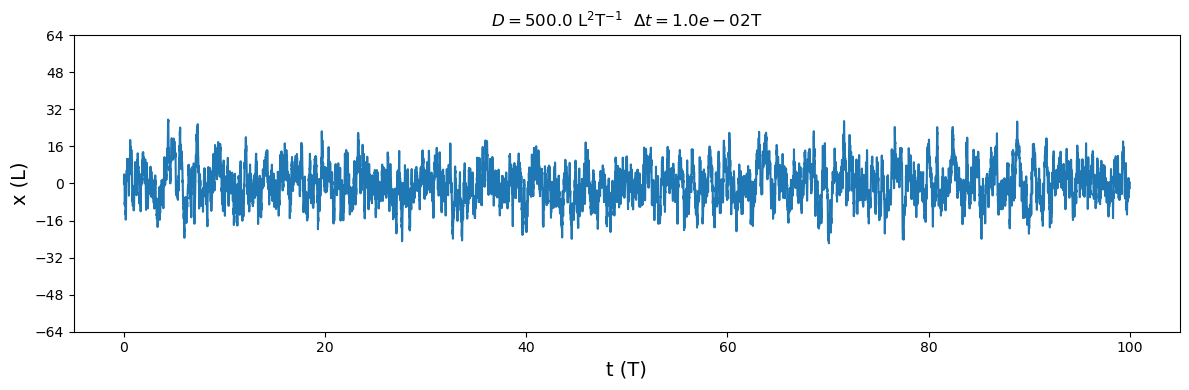

In [7]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: FEM to get $\psi'_i$ and $\lambda'_i$ when $D=1$

In [6]:
D_base = 1e0
eigenvalues_0, eigenvect_mat_0, rho_eq_by_fem_0 = fem_solve_eigen_by_pref(Nh, Np, xratio, xavg, p_eq, D_base, Nv)
weight_Qx_0 = get_weight_Qx(N, Nv, w0, eigenvect_mat_0);

### Part 5: $p(x,0)$

In [57]:
σ_delta = 2.0 # 0.8
k_delta = get_k_by_sigma(σ_delta)
idx = find_nearest_point(y_record[1], xref, e_norm, interpo_xs, Np)
p_t0 = get_gaussian(k_delta, xref, idx)
p_t0 = p_t0 / sum(w0 .* p_t0);
#sum(w0 .* p_t0)

alpha_t0_x = sqrt.(p_t0)
alpha_t0 = transpose(weight_Qx_0) * alpha_t0_x
alpha_t0_norm = norm(alpha_t0)
#sum(alpha_t0_x .* alpha_t0_x .* w0)

0.9999950210044996

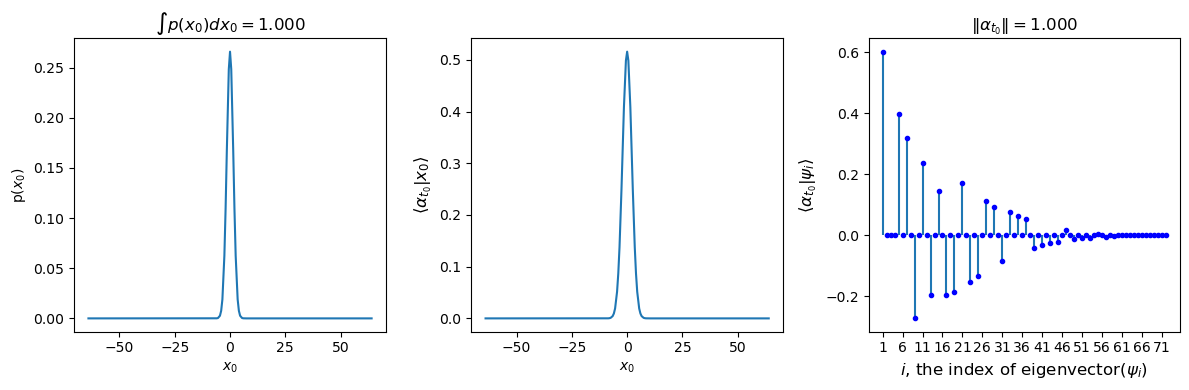

In [53]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p_t0)
ax.set_ylabel("p(\$x_0\$)")
ax.set_xlabel("\$x_0\$")
title = @sprintf "\$ \\int p(x_0)dx_0=%.3f \$" sum(alpha_t0_x .* alpha_t0_x .* w0)
ax.set_title(title)

ax = axes[2]
ax.plot(xref, alpha_t0_x)
ax.set_xlabel("\$x_0\$")
ax.set_ylabel("\$\\langle \\alpha_{t_0} | x_0 \\rangle\$", fontsize=12)

ax = axes[3]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t0, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t0)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\alpha_{t_0} | \\psi_i \\rangle\$", fontsize=12)
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)", fontsize=12)
title = @sprintf "\$  \\Vert \\alpha_{t_0} \\Vert =%.3f \$" alpha_t0_norm
ax.set_title(title)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t0_v0.pdf")
plt.show()

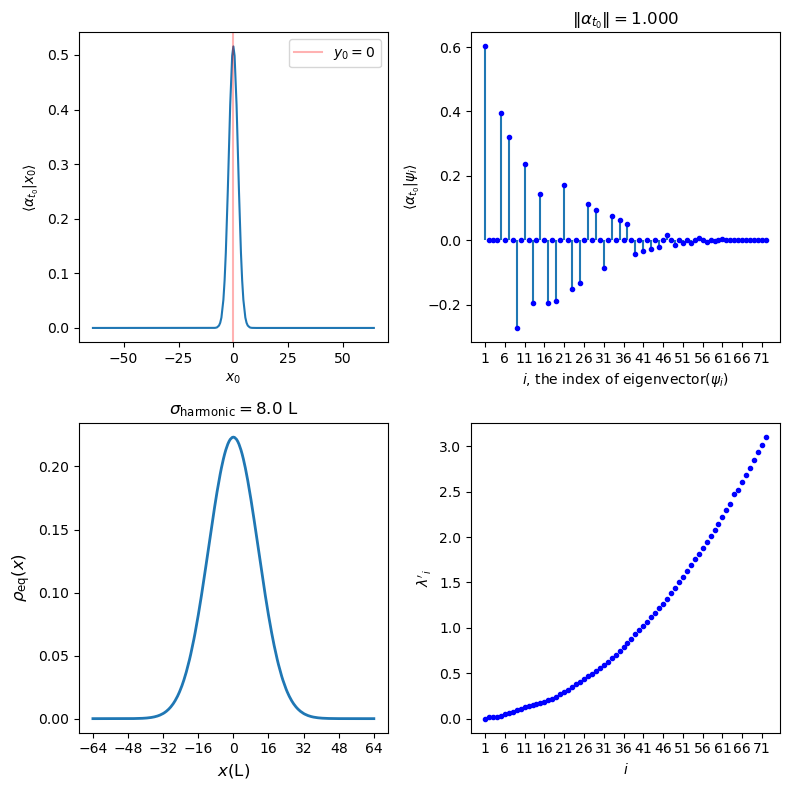

In [54]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8))

ax = axes[1,1]
ax.plot(xref, alpha_t0_x)
ax.axvline(y_record[1], color="red", alpha=0.3, label=@sprintf "\$y_0=%.0f\$" y_record[1])
ax.set_xlabel("\$x_0\$")
ax.set_ylabel("\$\\langle \\alpha_{t_0} | x_0 \\rangle\$")
ax.legend()

ax = axes[1,2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, alpha_t0, "b.")
ax.vlines(xarray, ymin=0, ymax=alpha_t0)
ax.set_xticks(xticks)
ax.set_ylabel("\$\\langle \\alpha_{t_0} | \\psi_i \\rangle\$")
ax.set_xlabel("\$ i \$, the index of eigenvector(\$ \\psi_i\$)")
title = @sprintf "\$  \\Vert \\alpha_{t_0} \\Vert =%.3f \$" alpha_t0_norm
ax.set_title(title)

ax = axes[2,1]
ax.plot(xref, rho_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$\\rho_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

ax = axes[2,2]
xarray = 1:72
xticks = 1:5:72
ax.plot(xarray, eigenvalues_0, "b.")
ax.set_xticks(xticks)
ax.set_ylabel("\$\\lambda'_i\$")
ax.set_xlabel("\$ i \$")

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/alpha_t0_v0.svg")
plt.show()

### Part 6: Update $D$

In [61]:
n_iter = 40
D_em_results = zeros(n_iter+1)
D_em_results[1] = 200. # Initial guess
for iter_id = 1:n_iter
    D_guess = D_em_results[iter_id]
    D_em_results[iter_id+1] = Diffusity.update_D(Np, Nphoton, save_freq, Nv, alpha_t0, D_guess, eigenvalues_0, 
        eigenvect_mat_0, xref, e_norm, interpo_xs, w0, y_record, k_delta)
end

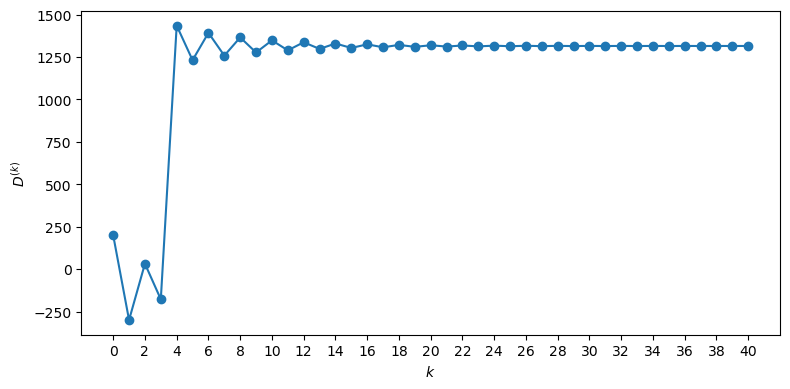

In [62]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

x_array = [iterid for iterid=0:n_iter]
ax.plot(x_array, D_em_results, "-o")
ax.set_xticks(0:2:n_iter)
ax.set_ylabel("\$D^{(k)}\$")
ax.set_xlabel("\$k\$")

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/D_EM_first_try.pdf")
plt.show()